In [1]:
from bstpp.main import LGCP_Model, Hawkes_Model, load_Chicago_Shootings, load_Boko_Haram
import numpyro.distributions as dist
import numpy as np

# Chicago Shootings Dataset

### Cox Hawkes Model

In [2]:
#load Chicago Shooting data
data = load_Chicago_Shootings()

In [3]:
column_names = ['UNEMP_DENS','MEDINC','MED_HV','assoc_plus','VACANT_DEN',
       'VAC_HU_pct','HCUND20K_L','POP_DENS','CT_SP_WCHI']
model = Hawkes_Model(data['events_2022'],#spatiotemporal points
                     data['boundaries'],#Chicago boundaries
                     365,#Time frame (1 yr)
                     True,#use Cox as background
                     spatial_cov=data['covariates'],#spatial covariate matrix
                     cov_names = column_names,#columns to use from covariates
                     a_0=dist.Normal(1,10), alpha = dist.Beta(20,60),#set priors
                     beta=dist.HalfNormal(2.0),sigmax_2=dist.HalfNormal(0.25)
                    )

/home/imanring/PointProcess/Cox_Hawkes_Cov/bstpp/main.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  args['A_area'] = A.area.sum()/((A_[0,1]-A_[0,0])*(A_[1,1]-A_[1,0]))
/home/imanring/PointProcess/Cox_Hawkes_Cov/bstpp/main.py:213: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersect['area'] = intersect.area/((A_[0,1]-A_[0,0])*(A_[1,1]-A_[1,0]))


100%|████████████████| 15000/15000 [31:50<00:00,  7.85it/s, init loss: -8037.3223, avg. loss [14251-15000]: -18324.6504]



SVI elapsed time: 1945.4223585128784


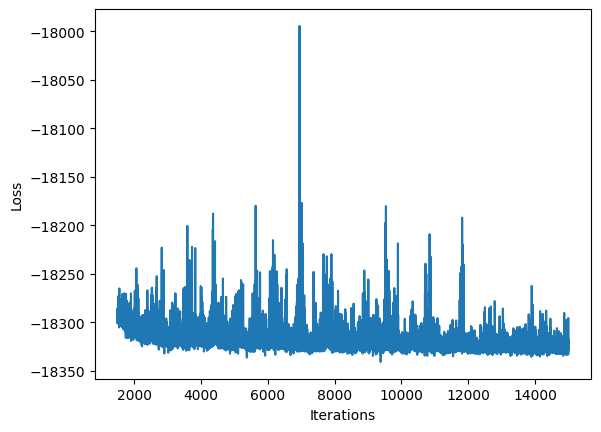

In [8]:
model.run_svi(lr=0.02,num_steps=15000)

In [5]:
model.log_expected_likelihood(data['events_2023'])

7510.46630859375

In [12]:
model.expected_AIC()

-18400.9453125

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
alpha,0.520330,0.027263,19.085665,0.000000e+00,0.466363,0.573409
beta,15.285158,0.919334,16.626341,0.000000e+00,13.571016,17.119894
sigmax_2,0.000014,0.000002,8.013816,1.110223e-15,0.000011,0.000018


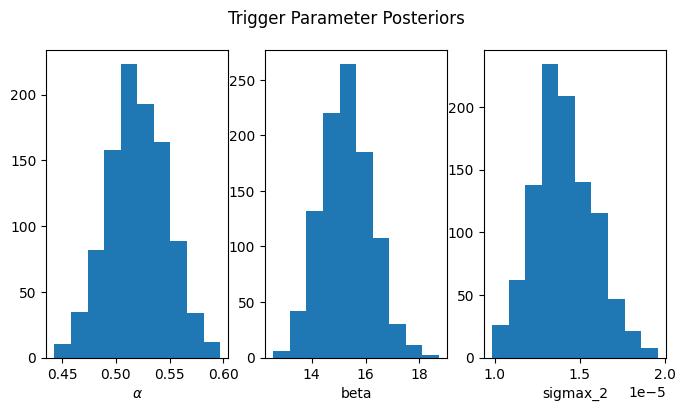

In [6]:
model.plot_trigger_posterior()

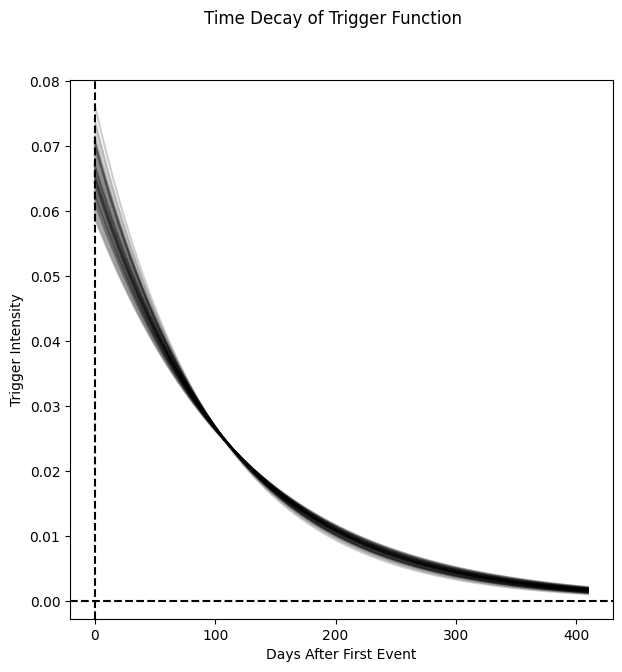

In [7]:
model.plot_trigger_time_decay()

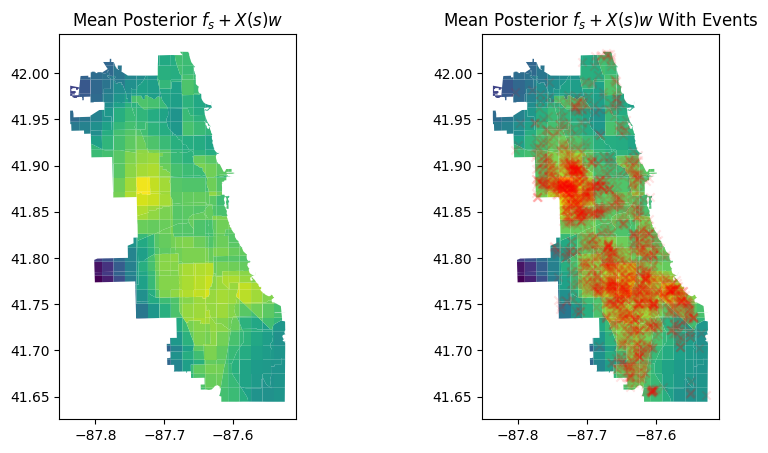

In [8]:
model.plot_spatial(include_cov=True)

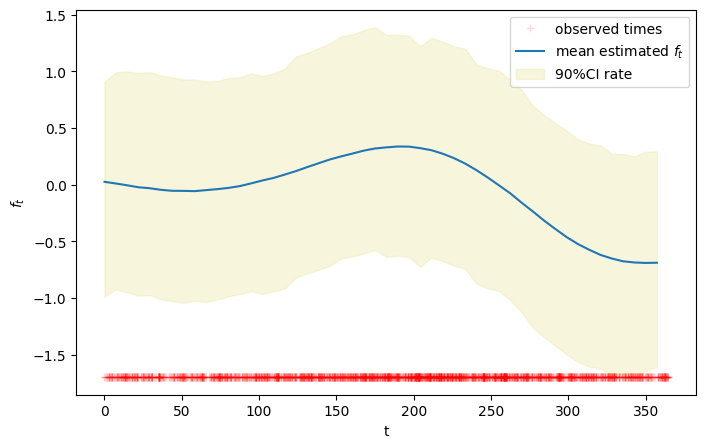

In [9]:
model.plot_temporal()

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
UNEMP_DENS,0.312386,0.077121,4.050601,0.000051,0.158358,0.456934
MEDINC,0.004424,0.093216,0.047456,0.962150,-0.191997,0.188561
MED_HV,-0.084747,0.112503,-0.753291,0.451275,-0.303382,0.135146
assoc_plus,-0.132593,0.090843,-1.459587,0.144404,-0.324232,0.041006
VACANT_DEN,0.113201,0.043158,2.622962,0.008717,0.026483,0.196128
VAC_HU_pct,0.090907,0.049570,1.833926,0.066665,-0.003047,0.190859
HCUND20K_L,0.102504,0.027050,3.789374,0.000151,0.049604,0.154991
POP_DENS,0.494260,0.054414,9.083347,0.000000,0.385863,0.595219
CT_SP_WCHI,-0.150656,0.053644,-2.808450,0.004978,-0.253478,-0.048819
a_0,2.715797,0.682109,3.981468,0.000068,1.324400,4.006296


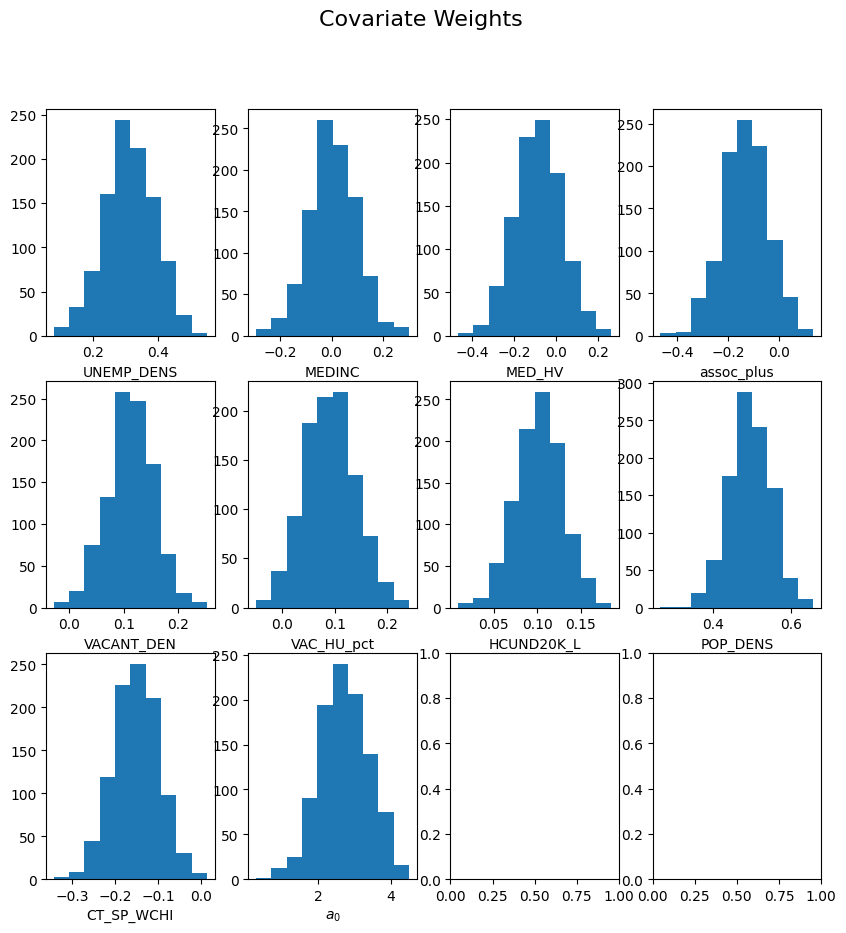

In [10]:
model.cov_weight_post_summary()

## Trigger function Extension
Here we define a spatial trigger function for an independent spatial double exponential distribution. The trigger is assumed to be a pdf and the reproduction rate is coded separately. The required methods to implement are:
- `compute_trigger`: compute the trigger function (pdf)
- `compute_integral`: compute the integral of the trigger function given limits (cdf)
- `get_par_names`: returns a list of the parameter names used in the trigger function

`simulate_trigger` is used only if a user wishes to simulate from the trigger function.

In [29]:
from bstpp.trigger import Trigger
import jax.numpy as jnp

class spatial_double_exp(Trigger):
    def compute_trigger(self,pars,dif_mat):
         return jnp.exp(-jnp.abs(dif_mat).sum(axis=0)/pars['Lambda'])/(2*pars['Lambda'])**2
    
    def compute_integral(self,pars,limits):
        x_limits = limits[0] #shape [2,n]
        y_limits = limits[1] #shape [2,n]
        x_int = 1-0.5*jnp.exp(-jnp.abs(x_limits[0]/pars['Lambda'])) - \
            0.5*jnp.exp(-jnp.abs(x_limits[1]/pars['Lambda']))
        y_int = 1-0.5*jnp.exp(-jnp.abs(y_limits[0]/pars['Lambda'])) - \
            0.5*jnp.exp(-jnp.abs(y_limits[1]/pars['Lambda']))
        return x_int*y_int
    
    def simulate_trigger(self,pars):
        return np.random.laplace(size=2,scale=pars['Lambda'])
    
    def get_par_names(self):
        return ['Lambda']

In [20]:
model = Hawkes_Model(data['events_2022'],#spatiotemporal points
                     data['boundaries'],#Chicago boundaries
                     365,#Time frame (1 yr)
                     True,#use Cox as background
                     spatial_cov=data['covariates'],#spatial covariate matrix
                     cov_names = column_names,#columns to use from covariates
                     a_0=dist.Normal(1,10), alpha = dist.Beta(20,60),#set priors
                     beta=dist.HalfNormal(2.0),Lambda=dist.HalfNormal(0.5),
                     spatial_trig=spatial_double_exp
                    )

/home/imanring/PointProcess/Cox_Hawkes_Cov/bstpp/main.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  args['A_area'] = A.area.sum()/((A_[0,1]-A_[0,0])*(A_[1,1]-A_[1,0]))
/home/imanring/PointProcess/Cox_Hawkes_Cov/bstpp/main.py:213: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersect['area'] = intersect.area/((A_[0,1]-A_[0,0])*(A_[1,1]-A_[1,0]))


100%|████████████████| 15000/15000 [22:27<00:00, 11.13it/s, init loss: -8969.3467, avg. loss [14251-15000]: -19033.2070]



SVI elapsed time: 1363.4761497974396


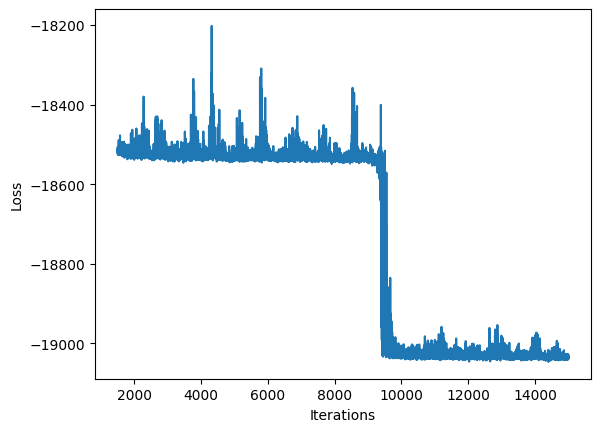

In [21]:
model.run_svi(lr=0.02,num_steps=15000)

In [22]:
model.expected_AIC()

-19106.455078125

In [23]:
model.log_expected_likelihood(data['events_2023'])

7807.57177734375

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
alpha,0.147088,0.008850,16.619843,0.0,0.130867,0.165129
beta,18.174726,1.008495,18.021637,0.0,16.244011,20.302648
Lambda,0.000098,0.000005,18.515415,0.0,0.000088,0.000109


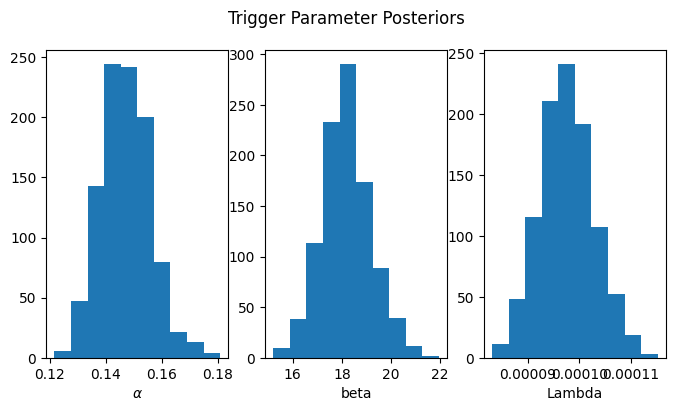

In [28]:
model.plot_trigger_posterior()

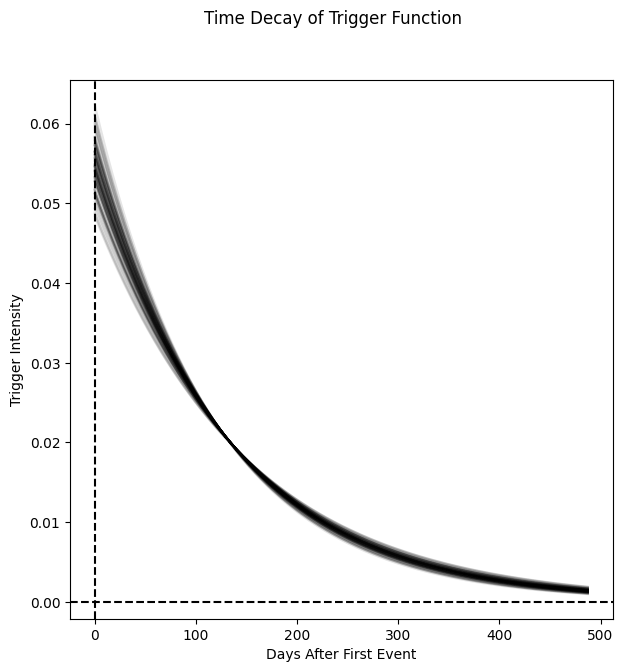

In [41]:
model.plot_trigger_time_decay()

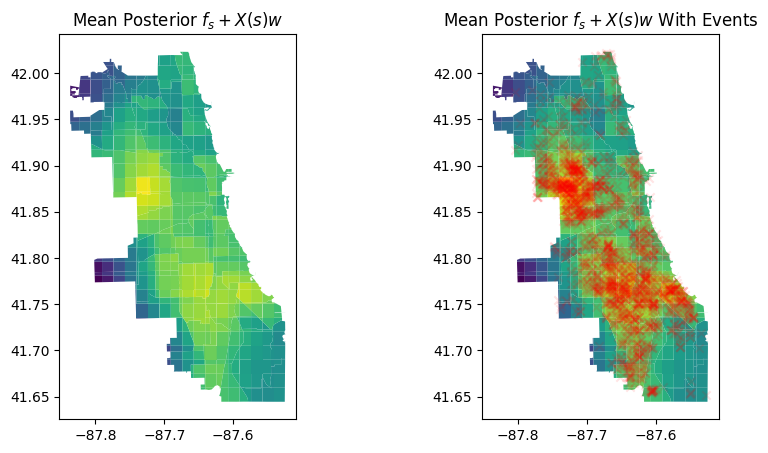

In [26]:
model.plot_spatial(include_cov=True)

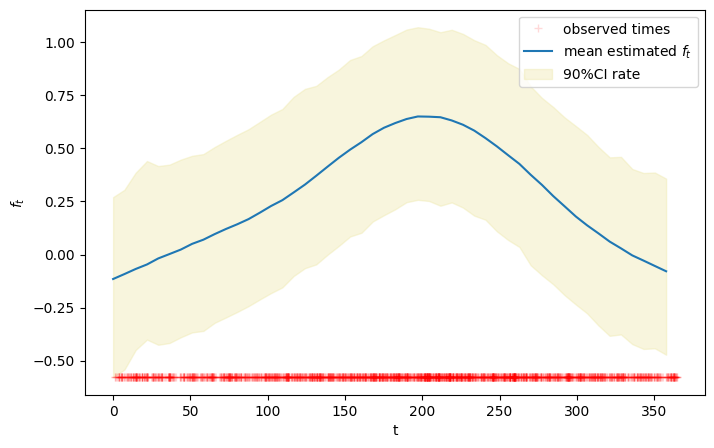

In [27]:
model.plot_temporal()

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
UNEMP_DENS,0.368023,0.045239,8.135174,4.440892e-16,0.281966,0.457796
MEDINC,-0.011645,0.062551,-0.186168,8.523131e-01,-0.133912,0.119011
MED_HV,-0.162242,0.073201,-2.216396,2.666441e-02,-0.301816,-0.011218
assoc_plus,-0.088143,0.067171,-1.312220,1.894458e-01,-0.213867,0.041958
VACANT_DEN,0.099696,0.027945,3.567549,3.603351e-04,0.045608,0.149519
VAC_HU_pct,0.023184,0.029211,0.793674,4.273854e-01,-0.031448,0.077794
HCUND20K_L,0.105068,0.019782,5.311227,1.088897e-07,0.065802,0.142814
POP_DENS,0.472448,0.038975,12.121694,0.000000e+00,0.397075,0.547998
CT_SP_WCHI,-0.165509,0.031963,-5.178058,2.242080e-07,-0.227017,-0.104208
a_0,3.025383,0.290694,10.407445,0.000000e+00,2.451419,3.595780


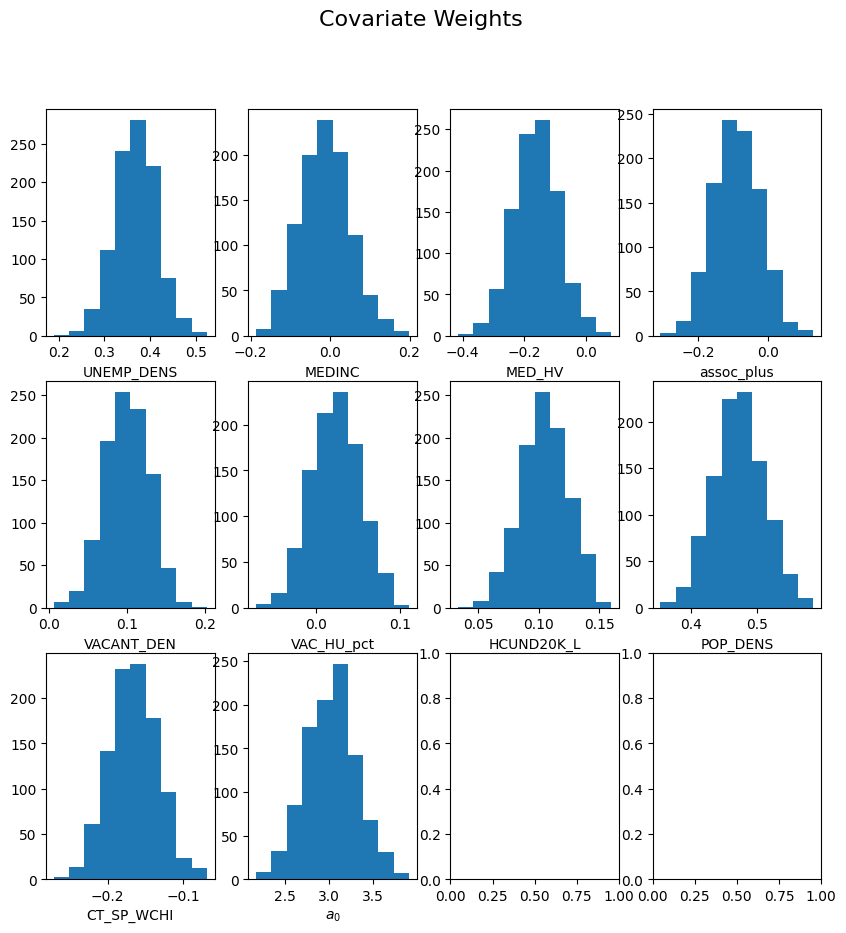

In [35]:
model.cov_weight_post_summary()

In [32]:
sample = model.simulate()

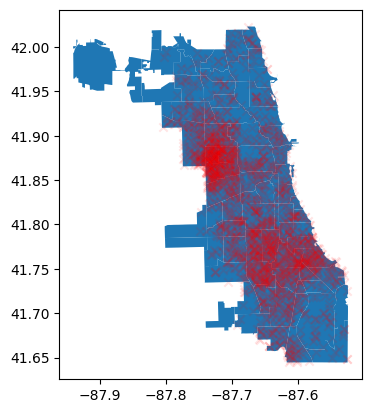

In [34]:
import matplotlib.pyplot as plt
ax = model.A.plot()
sample.plot(ax=ax,color='red',marker='x',alpha=0.1)
plt.show()

# Boko Haram Dataset

### Log Gaussian Cox Process Model

In [4]:
#load Boko Haram conflicts from Nigeria
data = load_Boko_Haram()
column_names = ['droughtstart_speibase', 'urban_ih_log', 'droughtyr_speigdm',
       'herb_gc', 'capdist', 'grass_ih_log', 'nlights_sd_log', 'water_gc_log',
       'pop_gpw_sd_log', 'pasture_ih']
lgcp_bh_model = LGCP_Model(data['events'],#event data
                           data['boundaries'],#boundary of events
                           data['events']['T'].max(),
                           spatial_cov=data['covariates'],#covariate matrix
                           cov_grid_size=(0.5,0.5),#grid cell width and height to construct spatial covariate grid
                           cov_names = column_names,#columns to use from covariates
                           a_0=dist.Normal(1,10)#set prior
                          )

In [5]:
lgcp_bh_model.run_mcmc()

sample: 100%|███████████████████████████| 1500/1500 [00:35<00:00, 41.85it/s, 511 steps of size 1.25e-02. acc. prob=0.95]



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
           a_0     -3.18      0.61     -3.19     -4.13     -2.16    491.08      1.00
          w[0]     -0.39      0.11     -0.39     -0.59     -0.22    658.23      1.00
          w[1]     -0.07      0.05     -0.07     -0.16     -0.00    651.68      1.00
          w[2]     -0.05      0.03     -0.05     -0.09      0.00    837.27      1.00
          w[3]      0.13      0.07      0.13      0.02      0.24    867.39      1.00
          w[4]      0.63      0.08      0.63      0.51      0.75   1055.48      1.00
          w[5]      0.18      0.04      0.18      0.12      0.23    906.50      1.00
          w[6]      0.78      0.04      0.78      0.72      0.86    927.72      1.00
          w[7]     -0.12      0.04     -0.12     -0.19     -0.05    994.49      1.00
          w[8]      0.78      0.08      0.78      0.67      0.93    661.91      1.00
          w[9]      0.58      0.05      0.58      0.50      0.67

In [6]:
lgcp_bh_model.expected_AIC()

-29747.21875

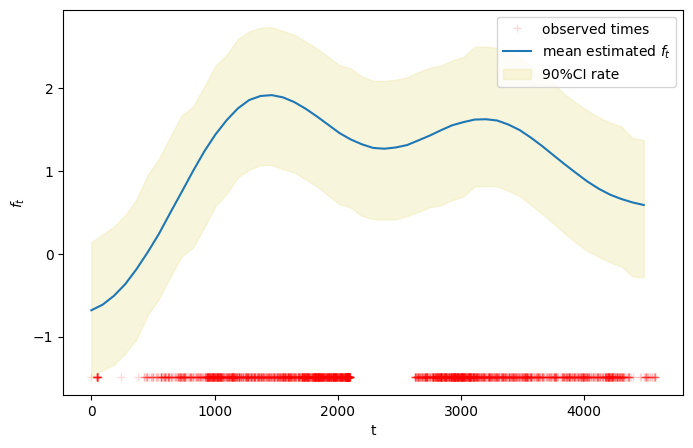

In [17]:
lgcp_bh_model.plot_temporal()

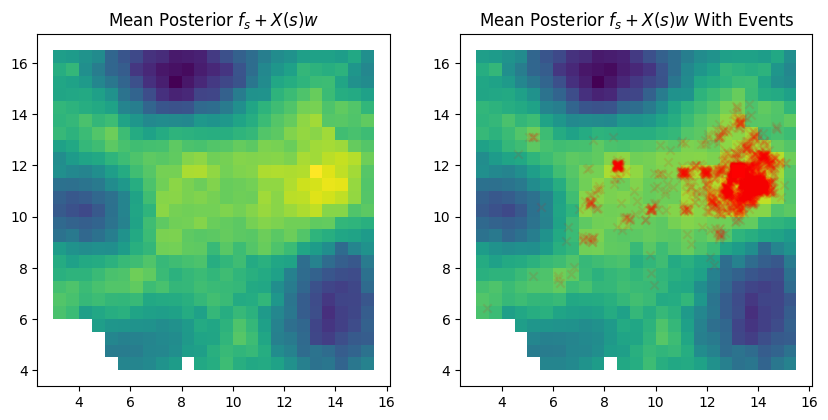

In [18]:
lgcp_bh_model.plot_spatial(include_cov=True)

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
droughtstart_speibase,-0.393704,0.113655,-3.464037,5.321333e-04,-0.616811,-0.171760
urban_ih_log,-0.068996,0.047387,-1.455993,1.453947e-01,-0.157801,0.025017
droughtyr_speigdm,-0.046708,0.028325,-1.649012,9.914511e-02,-0.098879,0.011444
herb_gc,0.128528,0.066626,1.929096,5.371897e-02,-0.001818,0.256239
capdist,0.631130,0.075291,8.382559,0.000000e+00,0.480287,0.783103
grass_ih_log,0.179572,0.036071,4.978258,6.415900e-07,0.108358,0.247056
nlights_sd_log,0.780560,0.042008,18.581089,0.000000e+00,0.700161,0.859844
water_gc_log,-0.122108,0.041723,-2.926630,3.426567e-03,-0.198359,-0.039363
pop_gpw_sd_log,0.782923,0.076487,10.236053,0.000000e+00,0.627051,0.931252
pasture_ih,0.582839,0.050643,11.508811,0.000000e+00,0.487036,0.681689


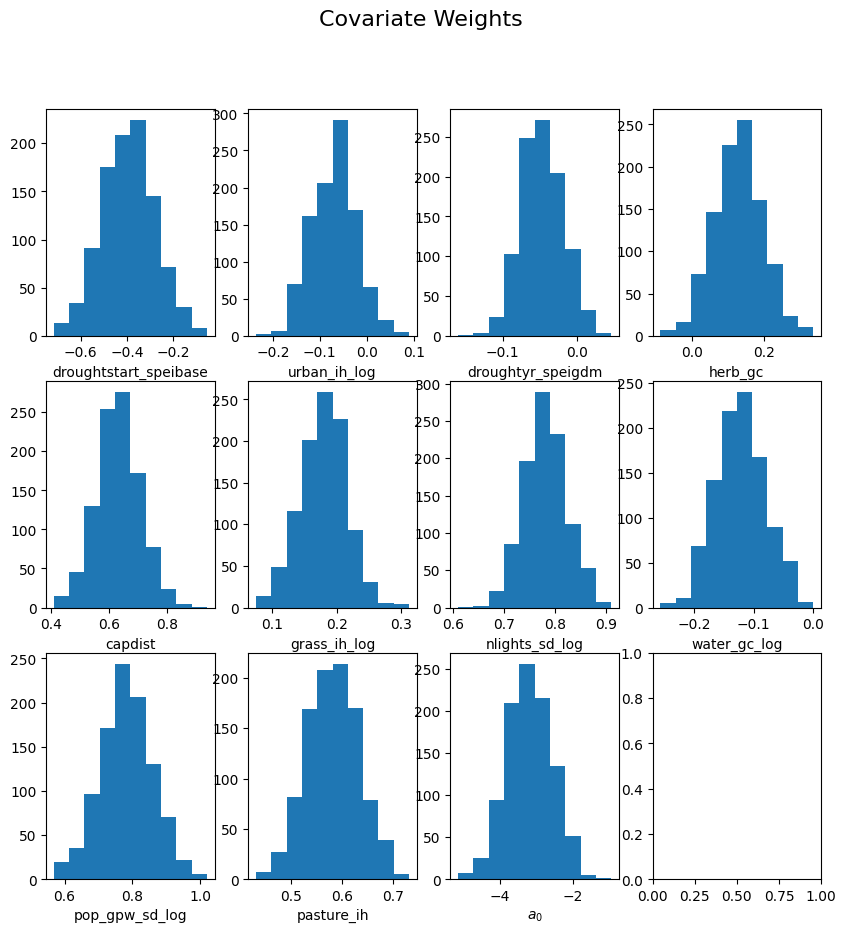

In [19]:
lgcp_bh_model.cov_weight_post_summary()